In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 

In [2]:
kSat = pd.read_csv("rosetta_outputs_bulkdens_updates.csv")
vSim = pd.read_excel('Amato_NEON_velocity results.xlsx', 
                     sheet_name=['Median Velocity','95th Velocity','99th Velocity'],
                       index_col = 0) 

In [11]:
def simple_mean_kSat(row, site, mult):
    potential_sensors = [f"sensor_depth_50{j}" for j in range(1,9)]
    derived_kSat = [np.nan]*len(potential_sensors)
    for i in np.arange(len(potential_sensors)):
        depth = potential_sensors[i]
        if depth in row.index:
            condition1 = (kSat["siteid"] == site)
            condition2 = (kSat["hzndept"]<= row[depth]) & (kSat["hzndepb"]>= row[depth])
            specific_kSat = kSat.loc[condition1 & condition2, "ksat_T"].mean()
            derived_kSat[i] = specific_kSat * mult
    return derived_kSat 

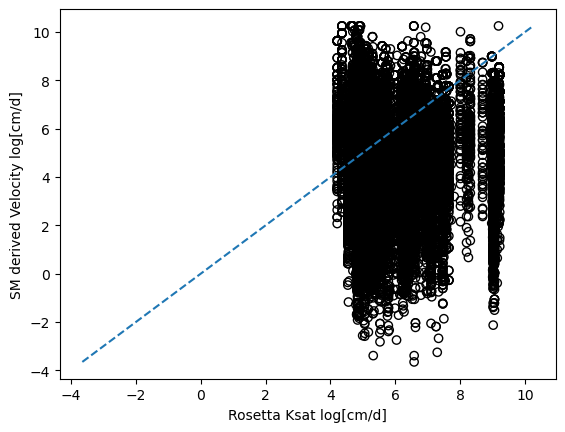

In [12]:
def load_pf_data(mlt):
    plt.figure()
  
    site_dir = "../PF_database_v2/"
    files = os.listdir(site_dir)
    sensors = [f"50{j}" for j in range(1,9)]
    names = [f"kSat_{j}" for j in sensors]
    max_ = -9999
    min_ = 9999
    for i in files:
        data = pd.read_csv(os.path.join(site_dir, i))
        data[names] = data.apply(simple_mean_kSat, args=(i.split("_")[0],mlt), axis = 1, result_type="expand")
        for j in sensors:
            if f"velocity_computed_{j}" in data.columns:
                if max_ < max(np.log(data[f"kSat_{j}"].max()), data[f"velocity_computed_{j}"].max()):
                    max_ = max(np.log(data[f"kSat_{j}"].max()), data[f"velocity_computed_{j}"].max())
                if min_ >  min(np.log(data[f"kSat_{j}"].min()), data[f"velocity_computed_{j}"].min()):
                    min_ = min(np.log(data[f"kSat_{j}"].min()), data[f"velocity_computed_{j}"].min())
                
                plt.scatter(np.log(data[f"kSat_{j}"]), data[f"velocity_computed_{j}"], facecolor = "none", 
                            edgecolors="black")
    plt.plot([min_, max_], [min_, max_], ls = "dashed")
    plt.xlabel("Rosetta Ksat log[cm/d]")
    plt.ylabel("SM derived Velocity log[cm/d]")
        ### get the corresponding ksat for each depth
load_pf_data(10)

In [5]:
def map_to_5cm_interval(value):
    lower_bound = int(value // 5) * 5
    upper_bound = lower_bound + 5
    return f'{lower_bound}-{upper_bound}cm'

In [6]:
def get_numerical_velocity(depth:float|int, site:str) -> list:
    median = np.exp(vSim["Median Velocity"])
    v_95 = np.exp(vSim["95th Velocity"]) 
    v_99 = np.exp(vSim["99th Velocity"])
    if pd.isna(depth) or (site not in median.index):
        return [np.nan] * 4
    
    useful_cols = median.columns[:-3]

    labels = []
    for j in np.arange(len(useful_cols)):
        split1 = useful_cols[j].split()[0]
        lower, upper = split1.split("-")
        upper = int(upper)
        lower = int(lower)
        # only one column satisfied 
        if (lower < depth < upper):
            labels = useful_cols[j]
        # both column satisfied right on the edge
        # then it should be the average between the two.
        elif (depth == upper) or (depth == lower):
            labels.append(useful_cols[j])  
   
    if labels:
        if isinstance(labels, list):
            # labeled as the larger depth.
            lb = labels[-1]
        else:
            lb = labels
        return  [s.loc[site, labels].mean() for s in [median, v_95, v_99]] + [lb]
    return [np.nan] * 4

In [7]:
kSat[["v_median", "v_95", "v_99", "range"]] = kSat.apply(lambda x: get_numerical_velocity(x["midpointcm"],
                                                                                          x["siteid"]), axis = 1, result_type="expand")


In [8]:
def plot(data, model_kSat, color_by_column, cmap = "plasma_r", alpha = 0.8):
    fig, ax = plt.subplots()
    
    # Create scatter plot colored by the specified column
    scatter = ax.scatter(data[model_kSat], data["v_99"]*3, 
                         c=data[color_by_column], 
                         cmap=cmap, alpha = alpha,
                         facecolor = "none")
    
    # Add colorbar
    plt.colorbar(scatter, label=color_by_column)
    
    ax.set_xlabel(f"{model_kSat} [cm/d]")
    ax.set_ylabel("Sim. Velocity [cm/d]")
    
    max_ = max(data[model_kSat].max(), data["v_99"].max())
    min_ = max(data[model_kSat].min(), data["v_99"].min())
    
    ax.plot([min_, max_], [min_, max_], 'k--')  # Added 'k--' for black dashed line
    
    plt.show()
# plot(kSat, "ksat_T", "midpointcm")
# plot(kSat, "ksat_TB","midpointcm")
# plot(kSat, "ksat_TBWC","midpointcm")

In [ ]:
import numpy as np

 

def depth_weighting(layers, sensor_depth):

    """

    Calculate depth weighting for multiple layers above the sensor depth.

   

    Parameters:

    layers (list of tuples): Each tuple contains (depth, weight) for a layer.

    sensor_depth (float): Depth of the sensor.

   

    Returns:

    np.array: Array of weighted values for each layer.

    """

    weighted_values = []

   

    for depth, weight in layers:

        if depth < sensor_depth:

            weighted_value = weight * (sensor_depth - depth)

            weighted_values.append(weighted_value)

        else:

            weighted_values.append(0)

   

    return np.array(weighted_values)

 

array([7.5, 4. , 0. ])